In [72]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd
import random
from pyvbmc import VBMC
from V_A_step_jump_fit_utils import rho_A_t_fn, cum_A_t_fn
from V_A_step_jump_fit_utils import CDF_hit_V_A_change

# params

In [36]:
N_sim = int(10e3)

dt = 1e-4
dB = np.sqrt(dt)


V_A_old = 1.8
V_A_new = 2.4
theta_A = 2

rate_lambda = 0.14
T_0 = 0.66 * (1e-3)
theta_E = 40.5

t_A_aff = 0.05
t_E_aff = 0
t_motor = 0

Z_E = 0
L = 0.5

N_print = int(100e5)

T_trunc = 0.3

# get LED times

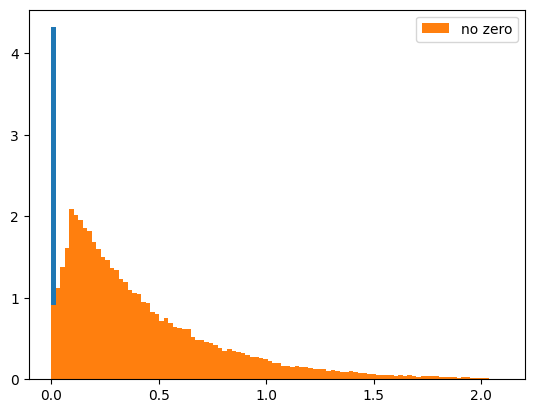

In [37]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# t_stim_and_led_tuple = [(row['intended_fix'], 
# row['LED_onset_time']) for _, row in df.iterrows()]

LED_times = (df['intended_fix'] - df['LED_onset_time']).values
plt.hist(LED_times, bins=100, density=True);

# remove zero from LED_times
LED_times = LED_times[LED_times != 0]
plt.hist(LED_times, bins=100, density=True, label='no zero');

LED_times = np.unique(LED_times)


stim_times = df['intended_fix'].values
stim_times = np.unique(stim_times)

plt.legend();

# Remove zero LED_onset_times
# filtered_df = df[df['intended_fix'] - df['LED_onset_time'] != 0]

# keep zero LED_onset_times
df = df[ df['LED_trial'] == 1]
tuple_column = list(zip(df['intended_fix'], df['intended_fix'] - df['LED_onset_time']))


# simulator

In [38]:
def psiam_tied_data_gen_wrapper(base_V_A, new_V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L, \
                                iter_num, N_print, dt):
    ABL = random.choice(ABL_arr)
    ILD = random.choice(ILD_arr)
    
    stim_led_pair = tuple_column[np.random.choice(len(tuple_column))]
    t_stim = stim_led_pair[0]
    t_led = stim_led_pair[1]

    # print after every N_print iterations
    if iter_num % N_print == 0:
        print(f'In iter_num: {iter_num}, ABL: {ABL}, ILD: {ILD}, t_stim: {t_stim}')

    # 1/3 chance of LED trial
    is_led_trial = random.random() < 1/3
    choice, rt, is_act, is_led_trial = simulate_psiam_tied(base_V_A, new_V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_led, t_A_aff, t_E_aff, t_motor, L, is_led_trial, dt)
    return {'choice': choice, 'rt': rt, 'is_act': is_act ,'ABL': ABL, 'ILD': ILD, 't_stim': t_stim, 't_led': t_led, 'is_led_trial': is_led_trial}

def simulate_psiam_tied(base_V_A, new_V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_led, t_A_aff, t_E_aff, t_motor, L, is_led_trial, dt):
    AI = 0; DV = Z_E; t = 0; dB = dt**0.5
    
    chi = 17.37; q_e = 1
    theta = theta_E * q_e
    mu = (2*q_e/T_0) * (10**(rate_lambda * ABL/20)) * np.sinh(rate_lambda * ILD/chi)
    sigma = np.sqrt( (2*(q_e**2)/T_0) * (10**(rate_lambda * ABL/20)) * np.cosh(rate_lambda * ILD/ chi) )
    
    is_act = 0
    while True:
        if t*dt < t_led or not is_led_trial:
            V_A = base_V_A
        elif t*dt >= t_led and is_led_trial:
            V_A = new_V_A

        if t*dt > t_stim + t_E_aff:
            DV += mu*dt + sigma*np.random.normal(0, dB)
        
        if t*dt > t_A_aff:
            AI += V_A*dt + np.random.normal(0, dB)
        
        t += 1
        
        if DV >= theta:
            choice = +1; RT = t*dt + t_motor
            break
        elif DV <= -theta:
            choice = -1; RT = t*dt + t_motor
            break
        
        if AI >= theta_A:
            is_act = 1
            AI_hit_time = t*dt
            # if t*dt > t_stim - t_motor:
            while t*dt <= (AI_hit_time + t_E_aff + t_motor):#  u can process evidence till stim plays
                if t*dt > t_stim + t_E_aff: # Evid accum wil begin only after stim starts and afferent delay
                    DV += mu*dt + sigma*np.random.normal(0, dB)
                    if DV >= theta:
                        DV = theta
                        break
                    elif DV <= -theta:
                        DV = -theta
                        break
                t += 1
            
            break
        
        
    if is_act == 1:
        RT = AI_hit_time + t_motor
        # if DV != 0:
        if DV >= (1 + (L/2) - 1)*theta:
            choice = 1
        elif DV <= (1 - (L/2) - 1)*theta:
            choice = -1
        else:
            prob_hit_up = (1/L)*((DV/theta) + 1) + (0.5 - (1/L))            
            if np.random.rand() <= prob_hit_up:
                choice = 1
            else:
                choice = -1
    
    return choice, RT, is_act, is_led_trial

In [55]:
sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper)(V_A_old, V_A_new, theta_A, np.unique(df['ABL'].values), np.unique(df['ILD'].values), \
                                                                       rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L, \
                                iter_num, N_print, dt) for iter_num in range(N_sim))

In iter_num: 0, ABL: 20, ILD: -4.0, t_stim: 0.379495112647841


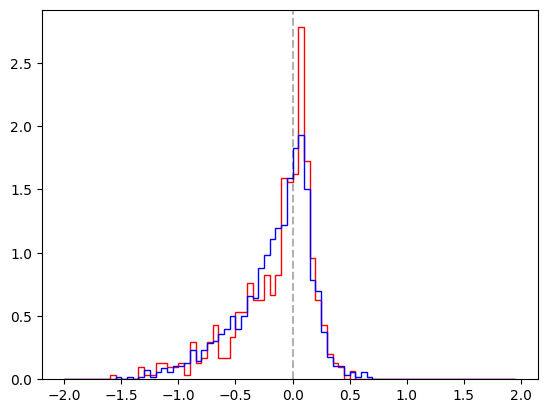

In [57]:
ON_trunc_aborts_aligned_to_led = []
for res in sim_results:
    if res['is_led_trial'] and res['rt'] > T_trunc and res['rt'] < res['t_stim']:
        ON_trunc_aborts_aligned_to_led.append(res['rt'] - res['t_led'])

OFF_trunc_aborts_aligned_to_stim = []
for res in sim_results:
    if not res['is_led_trial'] and res['rt'] > T_trunc and res['rt'] < res['t_stim']:
        OFF_trunc_aborts_aligned_to_stim.append(res['rt'] - res['t_led'])


bw_data = 0.05
bins_data = np.arange(-2, 2, bw_data)
plt.hist(ON_trunc_aborts_aligned_to_led, bins=bins_data, density=True, label='data', histtype='step', color='r');
plt.hist(OFF_trunc_aborts_aligned_to_stim, bins=bins_data, density=True, label='data', histtype='step', color='b');
plt.axvline(0, color='k', linestyle='--', label='LED onset', alpha=0.3);

In [40]:
num_aborts = len([ 1 for res in sim_results if res['rt'] < res['t_stim'] ]) 
print(f'% of aborts = {100*num_aborts/N_sim}')

% of aborts = 17.06


In [41]:
# num of aborts > T_trunc
num_aborts = len([ 1 for res in sim_results if res['rt'] < res['t_stim'] and res['rt'] > T_trunc ])
print(f'% of aborts > T_trunc = {100*num_aborts/N_sim}, # of aborts > T_trunc = {num_aborts}')

% of aborts > T_trunc = 16.93, # of aborts > T_trunc = 1693


# VBMC

In [ ]:
from V_A_step_jump_fit_utils import PDF_hit_V_A_change, CDF_hit_V_A_change


def compute_loglike(res, base_V_A, theta_A, t_A_aff):
    t_stim = res['t_stim']
    rt = res['rt']
    t_led = res['t_led']
    is_led_trial = res['is_led_trial']

    trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, base_V_A, theta_A)

    if is_led_trial: # ON
        if rt < T_trunc:
            likelihood = 0
        else:
            if rt < t_led: # its obviously less than t_stim
                likelihood = rho_A_t_fn(rt - t_A_aff, base_V_A, theta_A)/trunc_factor
            elif rt > t_led and rt < t_stim: # between led and stim
                if t_led <= T_trunc:
                    likelihood = 1
                else:
                    likelihood = (1 - cum_A_t_fn(t_led - t_A_aff, base_V_A, theta_A))/trunc_factor
            elif rt > t_stim: # after stim
                if t_stim <= T_trunc:
                    likelihood = 1
                else:
                    likelihood = (1 - cum_A_t_fn(t_stim - t_A_aff, base_V_A, theta_A))/trunc_factor


    else: # OFF
        if rt < T_trunc:
            likelihood = 0
        else:
            if rt < t_stim:
                likelihood = rho_A_t_fn(rt - t_A_aff, base_V_A, theta_A)/trunc_factor
            elif rt > t_stim:
                if t_stim <= T_trunc:
                    likelihood = 1
                else:
                    likelihood = (1 - cum_A_t_fn(t_stim - t_A_aff, base_V_A, theta_A))/trunc_factor
        

    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    



def psiam_tied_loglike_fn(params):
    base_V_A, theta_A, t_A_aff = params

    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike)(res, base_V_A, theta_A, t_A_aff) for res in sim_results)
                                   

    loglike = np.sum(all_loglike)
    return loglike

# bounds

In [43]:
base_V_A_bounds = [0.1, 5]
theta_A_bounds = [0.5, 5]
t_A_aff_bounds = [0.03, 0.07]

base_V_A_plausible_bounds = [0.5, 3]
theta_A_plausible_bounds = [1, 3]
t_A_aff_plausible_bounds = [0.04, 0.06]

# prior

In [44]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    base_V_A, theta_A, t_A_aff = params

    base_V_A_logpdf = trapezoidal_logpdf(base_V_A, base_V_A_bounds[0], base_V_A_plausible_bounds[0], base_V_A_plausible_bounds[1], base_V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    return base_V_A_logpdf + theta_A_logpdf + t_A_aff_logpdf

# joint

In [45]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + psiam_tied_loglike_fn(params)

# run vbmc

In [46]:
lb = [base_V_A_bounds[0], theta_A_bounds[0], t_A_aff_bounds[0]]
ub = [base_V_A_bounds[1], theta_A_bounds[1], t_A_aff_bounds[1]]

plb = [base_V_A_plausible_bounds[0], theta_A_plausible_bounds[0], t_A_aff_plausible_bounds[0]]
pub = [base_V_A_plausible_bounds[1], theta_A_plausible_bounds[1], t_A_aff_plausible_bounds[1]]

np.random.seed(42)
base_V_A_0 = np.random.uniform(base_V_A_plausible_bounds[0], base_V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])

x_0 = np.array([base_V_A_0, theta_A_0, t_A_aff_0])

In [47]:
vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -51042.771 +/-0.007.


# corner plot

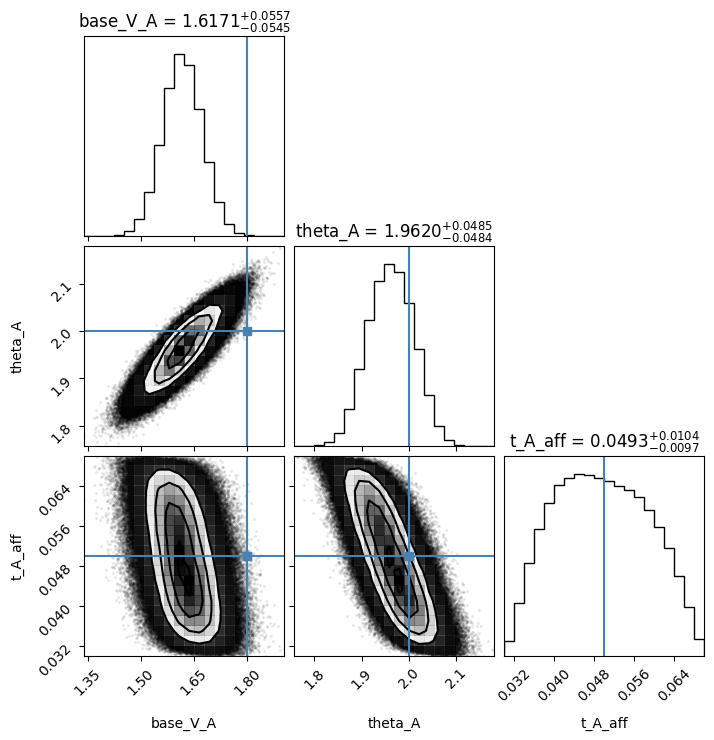

In [48]:
import corner
vp_samples = vp.sample(int(1e6))[0]
base_V_A_samp = vp_samples[:,0]
theta_A_samp = vp_samples[:,1]
t_A_aff_samp = vp_samples[:,2]

combined_samples = np.transpose(np.vstack((base_V_A_samp, theta_A_samp, t_A_aff_samp)))
param_labels = ['base_V_A', 'theta_A', 't_A_aff']
true_params = [V_A_old, theta_A, t_A_aff]
corner.corner (combined_samples, labels=param_labels, show_titles=True, title_fmt=".4f", truths=true_params  );


In [58]:
# ON_trunc_aborts_aligned_to_led, OFF_trunc_aborts_aligned_to_stim
num_ON_trunc_num_of_trials_between_led_and_stim = 0
for res in sim_results:
    if res['is_led_trial'] and res['rt'] > T_trunc and res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
        num_ON_trunc_num_of_trials_between_led_and_stim += 1

num_LED_on_trials = np.sum([1 for res in sim_results if res['is_led_trial']])

print(f'frac of aborts after LED onset in LED ON trials = {num_ON_trunc_num_of_trials_between_led_and_stim/num_LED_on_trials}')

frac of aborts after LED onset in LED ON trials = 0.07770169693361119


In [74]:
from tqdm import tqdm
base_V_A_mean = np.mean(base_V_A_samp)
t_A_aff_mean = np.mean(t_A_aff_samp)
theta_A_mean = np.mean(theta_A_samp)

new_V_A_possible = np.arange(base_V_A_mean, base_V_A_mean + 1, 0.05)
frac_of_aborts_btn_led_and_stim = np.zeros_like(new_V_A_possible)

for idx, new_V_A in tqdm(enumerate(new_V_A_possible), total=len(new_V_A_possible)):
    cdf_led_stim = []
    for res in sim_results:
        if res['is_led_trial']:
            t_led = res['t_led']
            t_stim = res['t_stim']

            t_led_prime = t_led - t_A_aff
            t_stim_prime = t_stim - t_A_aff
            T_trunc_prime = T_trunc - t_A_aff


            trunc_factor = 1 - CDF_hit_V_A_change(T_trunc_prime, base_V_A_mean, new_V_A, theta_A_mean, t_led_prime)
            cdf = CDF_hit_V_A_change(t_stim_prime, base_V_A_mean, new_V_A, theta_A_mean, t_led_prime) \
                    - CDF_hit_V_A_change(t_led_prime, base_V_A_mean, new_V_A, theta_A_mean, t_led_prime)
            
            cdf /= trunc_factor
            
            cdf_led_stim.append(cdf)
        
    frac_of_aborts_btn_led_and_stim[idx] = np.mean(cdf_led_stim)




  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [08:31<00:00, 25.57s/it]


Text(0.5, 1.0, 'new V_A = 2.367424624143898')

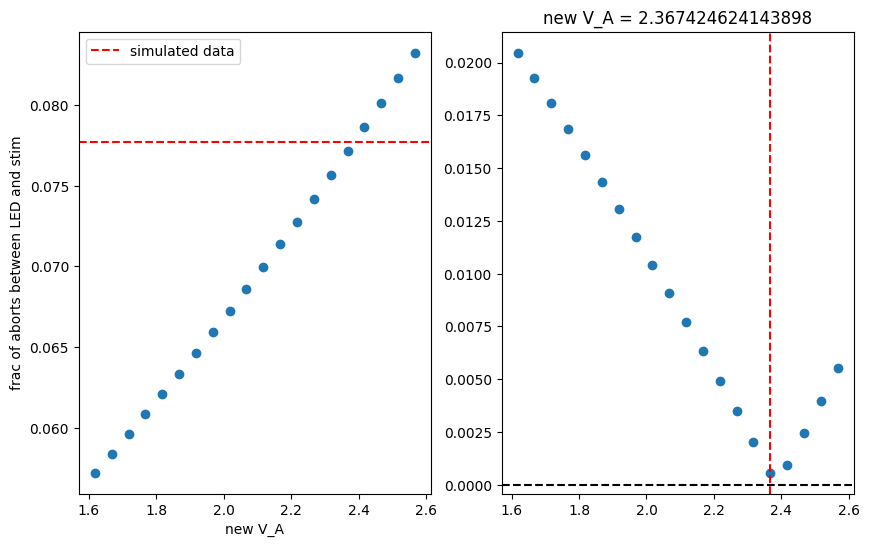

In [75]:
sim_data_frac = num_ON_trunc_num_of_trials_between_led_and_stim/num_LED_on_trials
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.scatter(new_V_A_possible, frac_of_aborts_btn_led_and_stim)
plt.axhline(sim_data_frac, color='r', linestyle='--', label='simulated data')
plt.xlabel('new V_A')
plt.ylabel('frac of aborts between LED and stim')

plt.legend();

plt.subplot(1,2,2)
diff = frac_of_aborts_btn_led_and_stim - sim_data_frac
plt.scatter(new_V_A_possible, np.abs(diff))

# close idx to zero in diff
idx = np.argmin(np.abs(diff))
plt.axvline(new_V_A_possible[idx], color='r', linestyle='--', label='new V_A')
plt.axhline(0, color='k', linestyle='--', label='zero diff')
plt.title(f'new V_A = {new_V_A_possible[idx]}')

In [77]:
new_V_A_matched = new_V_A_possible[idx]
print(f'new V_A matched = {new_V_A_matched}')
print(f'V_A_new = {V_A_new}')

new V_A matched = 2.367424624143898
V_A_new = 2.4
